In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception #to get pre-trained model Xception
#from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer #for text tokenization
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense#Keras to build our CNN and LSTM
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm #to check loop progress
tqdm().pandas()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


0it [00:00, ?it/s]

In [3]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
#from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
#from keras.utils import to_categorical

In [4]:
BASE_DIR = 'data_fil_Pro'
WORKING_DIR = 'working'

In [5]:
# Some urls are blocked from untrusted sites, the below code make python environment to trust every site
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [8]:
model1 = InceptionV3(weights='imagenet')
model = Model(model1.input, model1.layers[-2].output)

# summarize
print(model.summary())

96124928/96112376 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [9]:
# extract features from image
count = 0
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    if not img_name.startswith('.'):
    #print(img_name)
    # load the image from file
        img_path = directory + '/' + img_name
        image = load_img(img_path, target_size=(299,299))
        count = count+1
        #print(count)
        # convert image pixels to numpy array
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        # reshape data for model
        #image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # preprocess image for vgg
        image = preprocess_input(image)
        # extract features
        feature = model.predict(image, verbose=0)
        # get image ID
        image_id = img_name.split('.')[0]
        # store feature
        features[image_id] = feature

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1977 [00:00<?, ?it/s]

In [10]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_V3.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features_V3.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/1978 [00:00<?, ?it/s]

In [9]:
len(mapping)

1977

In [10]:
import re
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from random import sample

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('.', '')
            caption = re.sub(r"[^a-zA-Z0-9 ]", "", caption)
            #caption = caption.replace('[^A-Za-z]', '')
            caption =''.join((x for x in caption if not x.isdigit()))
            caption = caption.replace('jmf','')
            caption = caption.replace('xmm','')
            caption = caption.replace('cmmm','')
            caption = caption.replace('xxl','')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            #caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>2]) + ' endseq'
            caption = " ".join([word for word in caption.split() if len(word)>2])
            word_tokens = word_tokenize(caption)
            caption = " ".join([w for w in word_tokens if not w.lower() in stop_words])
            #caption = " ".join(sample(caption.split(),min(2, len(caption.split()))))
            caption = caption.split()[random.randint(0, len(caption.split())-1)]
            #print(caption)
            caption = 'startseq ' + caption + ' endseq'
            print(caption)
            captions[i] = caption


In [11]:
# before preprocess of text 
mapping['0_180_12_4']

['Fossil petrified mammoth molar tooth  14.4 cm']

In [12]:
# preprocess the text
clean(mapping)

startseq skull endseq
startseq skull endseq
startseq carved endseq
startseq tiger endseq
startseq handbag endseq
startseq leather endseq
startseq mod endseq
startseq alligator endseq
startseq retro endseq
startseq alligator endseq
startseq large endseq
startseq condition endseq
startseq outstanding endseq
startseq rare endseq
startseq rare endseq
startseq usa endseq
startseq foot endseq
startseq turtle endseq
startseq shells endseq
startseq shells endseq
startseq turtle endseq
startseq turtle endseq
startseq bridge endseq
startseq elephant endseq
startseq ivory endseq
startseq ivory endseq
startseq elephant endseq
startseq python endseq
startseq python endseq
startseq dragon endseq
startseq snakeskin endseq
startseq snakeskin endseq
startseq python endseq
startseq wallet endseq
startseq snakeskin endseq
startseq dragon endseq
startseq python endseq
startseq giant endseq
startseq expansa endseq
startseq jacket endseq
startseq jacket endseq
startseq fur endseq
startseq calfskin endseq
st

startseq good endseq
startseq ivory endseq
startseq ivory endseq
startseq good endseq
startseq good endseq
startseq tiger endseq
startseq kyoto endseq
startseq bone endseq
startseq tortoise endseq
startseq glazed endseq
startseq jizhou endseq
startseq glazed endseq
startseq shell endseq
startseq tortoise endseq
startseq shell endseq
startseq shell endseq
startseq tortoise endseq
startseq shell endseq
startseq rubies endseq
startseq feet endseq
startseq rubies endseq
startseq attached endseq
startseq brown endseq
startseq genuine endseq
startseq dog endseq
startseq dogs endseq
startseq leather endseq
startseq collars endseq
startseq collars endseq
startseq cut endseq
startseq earrings endseq
startseq bags endseq
startseq earrings endseq
startseq lizard endseq
startseq taxidermy endseq
startseq lizard endseq
startseq lizard endseq
startseq taxidermy endseq
startseq lizard endseq
startseq taxidermy endseq
startseq lizard endseq
startseq taxidermy endseq
startseq lizard endseq
startseq liz

startseq natural endseq
startseq shells endseq
startseq turtle endseq
startseq natural endseq
startseq natural endseq
startseq shells endseq
startseq shells endseq
startseq turtle endseq
startseq shells endseq
startseq natural endseq
startseq shells endseq
startseq hair endseq
startseq hair endseq
startseq cheetah endseq
startseq cheetah endseq
startseq scarf endseq
startseq cheetah endseq
startseq scarf endseq
startseq panels endseq
startseq wash endseq
startseq wash endseq
startseq cheetah endseq
startseq cowhide endseq
startseq leather endseq
startseq panels endseq
startseq cheetah endseq
startseq baby endseq
startseq cheetah endseq
startseq beige endseq
startseq garzarara endseq
startseq pony endseq
startseq garzarara endseq
startseq printed endseq
startseq bcv endseq
startseq khaki endseq
startseq khaki endseq
startseq python endseq
startseq python endseq
startseq khaki endseq
startseq post endseq
startseq post endseq
startseq leather endseq
startseq post endseq
startseq boots end

startseq genuine endseq
startseq gator endseq
startseq alligator endseq
startseq taxidermy endseq
startseq genuine endseq
startseq alligator endseq
startseq idea endseq
startseq wallet endseq
startseq made endseq
startseq alligator endseq
startseq bifold endseq
startseq wallet endseq
startseq mens endseq
startseq mens endseq
startseq gift endseq
startseq aselife endseq
startseq alligator endseq
startseq aselife endseq
startseq alligator endseq
startseq energy endseq
startseq zoology endseq
startseq bat endseq
startseq oddity endseq
startseq zoo endseq
startseq top endseq
startseq zoo endseq
startseq top endseq
startseq bat endseq
startseq insect endseq
startseq base endseq
startseq lizard endseq
startseq lizard endseq
startseq lizard endseq
startseq lizard endseq
startseq skeleton endseq
startseq skeleton endseq
startseq mammal endseq
startseq taxidermy endseq
startseq ball endseq
startseq claw endseq
startseq bat endseq
startseq display endseq
startseq bat endseq
startseq decor endseq

In [13]:
# after preprocess of text
mapping['0_180_12_4']

['startseq mammoth endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

1977

In [16]:
all_captions[:10]

['startseq skull endseq',
 'startseq skull endseq',
 'startseq carved endseq',
 'startseq tiger endseq',
 'startseq handbag endseq',
 'startseq leather endseq',
 'startseq mod endseq',
 'startseq alligator endseq',
 'startseq retro endseq',
 'startseq alligator endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

541

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

3

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(decoder1)
outputs = Dense(vocab_size, activation='softmax', kernel_regularizer =tf.keras.regularizers.l2(l=0.01))(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [23]:
# train the model
early_stopping_cb = EarlyStopping(monitor="val_loss", patience=2)

epochs = 50
batch_size = 64
steps = len(train) // batch_size
val_steps = len(test) // batch_size
hist = model.fit(data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size),
                steps_per_epoch=steps, epochs=50,
                callbacks = [early_stopping_cb],
                validation_data=data_generator(test, mapping, features, tokenizer, max_length, vocab_size, batch_size),
                validation_steps=val_steps,
                 verbose=1)

Epoch 1/50
27/27 [==============================] - 7s 122ms/step - loss: 12.0832 - val_loss: 9.3650
Epoch 2/50
27/27 [==============================] - 2s 65ms/step - loss: 7.2552 - val_loss: 6.0292
Epoch 3/50
27/27 [==============================] - 2s 68ms/step - loss: 5.1257 - val_loss: 4.8145
Epoch 4/50
27/27 [==============================] - 2s 69ms/step - loss: 4.2269 - val_loss: 4.2412
Epoch 5/50
27/27 [==============================] - 2s 66ms/step - loss: 3.7581 - val_loss: 3.8658
Epoch 6/50
27/27 [==============================] - 2s 69ms/step - loss: 3.4959 - val_loss: 3.6650
Epoch 7/50
27/27 [==============================] - 2s 69ms/step - loss: 3.3300 - val_loss: 3.5988
Epoch 8/50
27/27 [==============================] - 2s 69ms/step - loss: 3.2076 - val_loss: 3.5240
Epoch 9/50
27/27 [==============================] - 2s 68ms/step - loss: 3.1397 - val_loss: 3.4662
Epoch 10/50
27/27 [==============================] - 2s 76ms/step - loss: 3.0844 - val_loss: 3.4269
Epoch 1

In [23]:
"""# train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)"""

'# train the model\nepochs = 20\nbatch_size = 32\nsteps = len(train) // batch_size\n\nfor i in range(epochs):\n    # create data generator\n    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)\n    # fit for one epoch\n    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)'

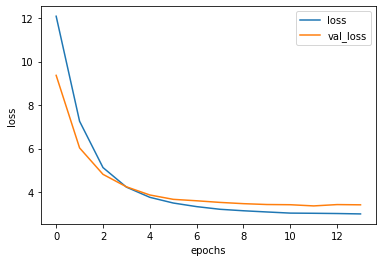

In [24]:
import matplotlib.pyplot as plt
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [25]:
# save the model
#model.save(WORKING_DIR+'/best_model_filter.h5')

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/198 [00:00<?, ?it/s]

BLEU-1: 0.666667
BLEU-2: 0.000000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram o

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq alligator endseq
--------------------Predicted--------------------
startseq leather endseq


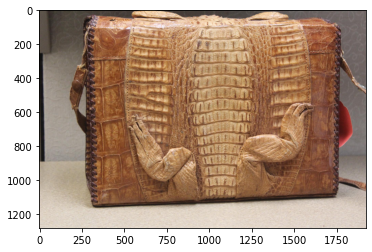

In [29]:
generate_caption("0_0_0_2.jpg")


---------------------Actual---------------------
startseq ivory endseq
--------------------Predicted--------------------
startseq tooth endseq


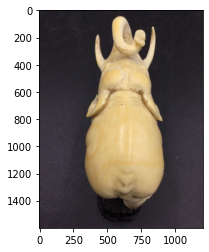

In [30]:
generate_caption("0_175_22_2.jpg")


---------------------Actual---------------------
startseq mammoth endseq
--------------------Predicted--------------------
startseq tooth endseq


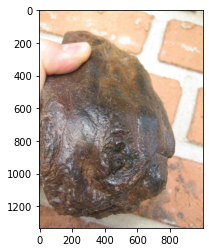

In [31]:
generate_caption("0_180_12_4.jpg")


---------------------Actual---------------------
startseq skeleton endseq
--------------------Predicted--------------------
startseq tooth endseq


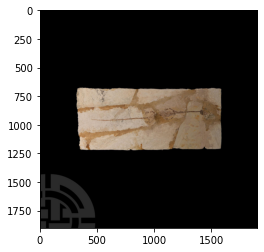

In [32]:
generate_caption("0_477_4_0.jpg")


---------------------Actual---------------------
startseq lion endseq
--------------------Predicted--------------------
startseq tooth endseq


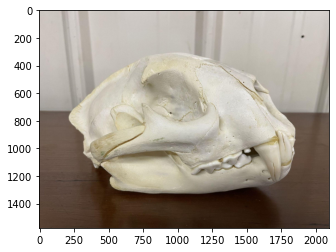

In [33]:
generate_caption("0_300_0_0.jpg")


---------------------Actual---------------------
startseq cocktail endseq
--------------------Predicted--------------------
startseq leather endseq


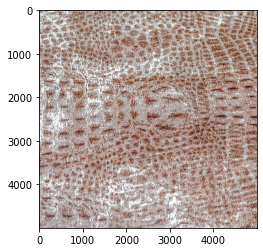

In [34]:
generate_caption("0_147_10_3.jpg")


---------------------Actual---------------------
startseq african endseq
--------------------Predicted--------------------
startseq tooth endseq


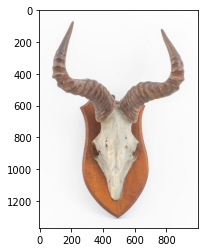

In [35]:
generate_caption("0_179_30_2.jpg")

---------------------Actual---------------------
startseq lizard endseq
--------------------Predicted--------------------
startseq tooth endseq


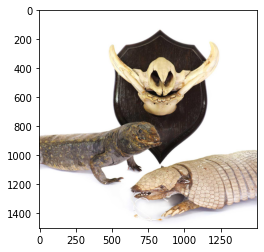

In [36]:
generate_caption("0_316_0_4.jpg")

In [37]:
test

['0_555_10_0',
 '0_555_10_1',
 '0_555_10_3',
 '0_555_10_2',
 '0_555_4_4',
 '0_555_4_5',
 '0_555_4_7',
 '0_555_4_6',
 '0_555_4_2',
 '0_555_4_3',
 '0_555_4_1',
 '0_555_4_0',
 '0_555_12_4',
 '0_555_12_5',
 '0_555_12_7',
 '0_555_12_6',
 '0_555_12_2',
 '0_555_12_3',
 '0_555_12_1',
 '0_555_12_0',
 '0_555_12_8',
 '0_555_12_9',
 '0_555_2_2',
 '0_555_2_3',
 '0_555_2_1',
 '0_555_2_0',
 '0_555_2_4',
 '0_154_6_5',
 '0_154_6_4',
 '0_154_6_0',
 '0_154_6_1',
 '0_154_6_3',
 '0_154_6_2',
 '0_154_2_2',
 '0_154_2_3',
 '0_154_2_1',
 '0_154_2_0',
 '11_161_0_0',
 '11_161_0_1',
 '11_161_0_3',
 '11_161_0_2',
 '11_161_0_5',
 '11_161_0_4',
 '11_161_4_4',
 '11_161_4_5',
 '11_161_4_6',
 '11_161_4_2',
 '11_161_4_3',
 '11_161_4_1',
 '11_161_4_0',
 '11_161_3_1',
 '11_161_3_0',
 '11_161_3_2',
 '11_161_2_2',
 '11_161_2_3',
 '11_161_2_1',
 '11_161_2_0',
 '11_161_2_4',
 '0_361_2_2',
 '0_361_2_3',
 '0_361_2_1',
 '0_361_2_0',
 '0_357_0_9',
 '0_357_0_8',
 '0_357_0_0',
 '0_357_0_11',
 '0_357_0_10',
 '0_357_0_1',
 '0_357_0_3

---------------------Actual---------------------
startseq mount endseq
--------------------Predicted--------------------
startseq tooth endseq


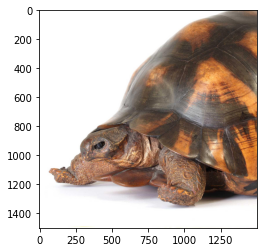

In [38]:
generate_caption("0_555_10_0.jpg")

---------------------Actual---------------------
startseq bone endseq
--------------------Predicted--------------------
startseq leather endseq


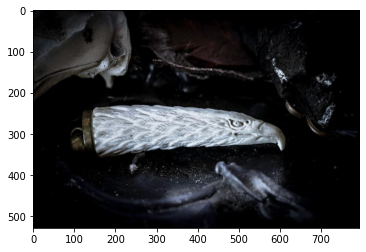

In [39]:
generate_caption("11_161_3_2.jpg")

---------------------Actual---------------------
startseq tiger endseq
--------------------Predicted--------------------
startseq leather endseq


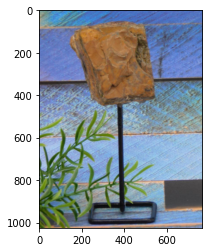

In [40]:
generate_caption("0_539_46_0.jpg")

---------------------Actual---------------------
startseq cigar endseq
--------------------Predicted--------------------
startseq leather endseq


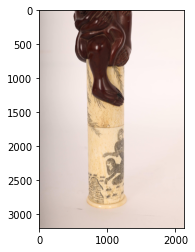

In [41]:
generate_caption("0_357_0_10.jpg")

---------------------Actual---------------------
startseq silverplate endseq
--------------------Predicted--------------------
startseq tooth endseq


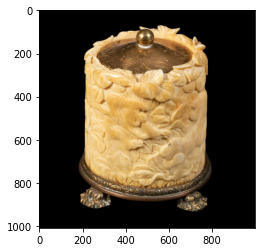

In [42]:
generate_caption("0_361_2_0.jpg")